# Project Title: 
Store Sales - Time Series Forecasting

# Business Understanding

## 1. Introduction
This project focuses on time series forecasting to predict store sales for Corporation Favorita, a large Ecuadorian-based grocery retailer. The objective is to build a model that accurately predicts the unit sales for thousands of items sold at different Favorita stores.


### 1.1. Objectives
Understand the data: The first objective is to gain insights into the store sales data, including store-specific information, product families, promotions, and sales numbers. This understanding will enable the company to make informed business decisions.

Predict store sales: Develop a reliable time series forecasting model that accurately predicts the unit sales for different product families at various Favorita stores. This will help the company optimize inventory management, plan promotions, and improve overall sales performance.

### 1.2. Methodology
To achieve the objectives, we will follow a structured approach:

Data Exploration: Thoroughly explore the provided datasets to understand the available features, their distributions, and relationships. This step will provide initial insights into the store sales data and help identify any data quality issues.

Data Preparation: Handle missing values, perform feature engineering, and encode categorical variables as necessary. This step may involve techniques like imputation, scaling, and one-hot encoding.

Time Series Analysis: Analyze the temporal aspects of the data, including trends, seasonality, and potential outliers. This analysis will provide a deeper understanding of the underlying patterns in store sales over time.

Model Selection and Training: Select appropriate time series forecasting models and train them using the prepared data. Consider incorporating external factors like promotions, holidays, and oil prices, if available, to enhance the forecasting accuracy.

Model Evaluation: Evaluate the trained models using appropriate metrics, such as mean absolute error (MAE), root mean squared error (RMSE), or mean absolute percentage error (MAPE). Assess the models' performance and identify the most accurate and reliable forecasting model.

Model Deployment and Forecasting: Deploy the chosen model to predict store sales for future time periods, leveraging the provided test dataset. Generate forecasts for the target period and assess the model's ability to capture the sales patterns accurately.

By following this methodology, we aim to provide valuable insights to the telecom company and develop a reliable predictive model for customer churn.

# Setup

## Installations

In [1]:
# %pip install pyodbc

## Importation

In [2]:
# Data Handling
import pyodbc
from dotenv import dotenv_values
import numpy as np
import pandas as pd
from sklearn.impute import SimpleImputer


# Visualization
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns

# Other Packages
import warnings

warnings.filterwarnings("ignore")

## Data Loading

### Loading the data from SQL database

In [3]:
# Load environment variables from the .env file into a dictionary
environment_vars = dotenv_values('.env')

# Get the credential values from the '.env' file 
server = environment_vars.get("SERVER")
database = environment_vars.get("DATABASE")
username = environment_vars.get("USERNAME")
password = environment_vars.get("PASSWORD")

# Create the connection string using the ODBC driver format
conn_str = f'DRIVER={{ODBC Driver 17 for SQL Server}};SERVER={server};DATABASE={database};UID={username};PWD={password}'

# Establish the connection using the connection string
conn = pyodbc.connect(conn_str)

In [4]:
# Query the first table 'oil' in the database
query1 = 'SELECT * FROM dbo.oil'
oil_df = pd.read_sql(query1, conn)

# Query the second table 'holidays_events' in the database
query2 = 'SELECT * FROM dbo.holidays_events'
holidays_events_df = pd.read_sql(query2, conn)

# Query the third table 'stores' in the database
query3 = 'SELECT * FROM dbo.stores'
stores_df = pd.read_sql(query3, conn)

In [5]:
# Close connection
conn.close()

In [6]:
# Display the dataframe
oil_df.head()

,date,dcoilwtico
0,2013-01-01,NaN
1,2013-01-02,93.139999
2,2013-01-03,92.970001
3,2013-01-04,93.120003
4,2013-01-07,93.199997


In [7]:
# Display the dataframe
holidays_events_df.head()

,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False


In [8]:
# Display the dataframe
stores_df.head()

,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4


### Loading the Train and Test Datasets

#### Train Dataset

In [9]:
train_df = pd.read_csv("train.csv")
train_df.head()

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,1,2013-01-01,1,BABY CARE,0.0,0
2,2,2013-01-01,1,BEAUTY,0.0,0
3,3,2013-01-01,1,BEVERAGES,0.0,0
4,4,2013-01-01,1,BOOKS,0.0,0


#### Test Dataset

In [10]:
test_df = pd.read_csv("test.csv")
test_df.head()

,id,date,store_nbr,family,onpromotion
0,3000888,2017-08-16,1,AUTOMOTIVE,0
1,3000889,2017-08-16,1,BABY CARE,0
2,3000890,2017-08-16,1,BEAUTY,2
3,3000891,2017-08-16,1,BEVERAGES,20
4,3000892,2017-08-16,1,BOOKS,0


### Loading the Transactions Dataset

In [11]:
transactions_df = pd.read_csv("transactions.csv")
transactions_df.head()

,date,store_nbr,transactions
0,2013-01-01,25,770
1,2013-01-02,1,2111
2,2013-01-02,2,2358
3,2013-01-02,3,3487
4,2013-01-02,4,1922


# Questions and Hypothesis

## Hypothesis

The promotional activities, oil prices, and holidays/events have a significant impact on store sales for Corporation Favorita.

Null Hypothesis (H0): The promotional activities, oil prices, and holidays/events do not have a significant impact on store sales for Corporation Favorita.

Alternative Hypothesis (H1): The promotional activities, oil prices, and holidays/events have a significant impact on store sales for Corporation Favorita.

## Questions
1. Is the train dataset complete, including all the required dates?
2. Which dates have the lowest and highest sales for each year?
3. Did the earthquake have an impact on sales?
4. Are certain groups of stores selling more products? (Cluster, city, state, type)
5. Are sales affected by promotions, oil prices, and holidays?
6. What analysis can be derived from the date and its extractable features?
7. What is the difference between RMSLE, RMSE, MSE (or why is the MAE greater than all of them?)

Key Analytical Questions:

1. How does the presence of promotional activities affect store sales?

2. What is the relationship between oil prices and store sales?

3. Do holidays and events influence store sales? Are there specific holidays/events that drive higher sales?

4. How does the historical sales trend vary across different stores and product families?

    a. Are there certain product families types that exhibit higher sales performance?
    b. Are there any notable correlations between variables such as store size, location, or cluster, and sales performance?

5. Is there any seasonality or trend (recurring patterns) in the store sales data?

6. Can we identify any specific time periods or events that led to significant changes in store sales?

7. How does store transaction volume (number of transactions) correlate with sales? Are there any insights to be gained from transaction data?

9. Does store sales vary based on the day of the week or month of the year?

# Exploratory Data Analysis: EDA

## Understanding the datasets

An in-depth exploration of the datasets is presented to gain insights into the available variables,their distributions and relationships. This step will provide an initial undertanding of the datasets to identify any data quality issues that will inform the cleaning and pre-processing.

### i. Shape of The Datasets

In [12]:
# Print out the shapes of the train and test datasets
print(f"Train Dataset: {train_df.shape}")
print(f"Test Datasets: {test_df.shape}")

Train Dataset: (3000888, 6)
Test Datasets: (28512, 5)



The train dataset contains 3,000,888 rows and 6 columns while the test dataset contains 28,512 rows and 5 columns.

The train dataset is significantly larger than the test dataset in terms of the number of rows. This is expected, as the train dataset is usually larger to provide sufficient data for model training.

In [13]:
# Print out the shapes of the other datasets
print("Shapes of Each Dataset:")
print(f"Holiday Events Dataset: {holidays_events_df.shape}")
print(f"Oil Dataset: {oil_df.shape}")
print(f"Stores Dataset: {stores_df.shape}")
print(f"Transactions Dataset: {transactions_df.shape}")

Shapes of Each Dataset:
Holiday Events Dataset: (350, 6)
Oil Dataset: (1218, 2)
Stores Dataset: (54, 5)
Transactions Dataset: (83488, 3)


The Holiday Events dataset contains 350 rows and 6 columns. This dataset provides information about various holidays and events.

The Oil dataset consists of 1,218 rows and 2 columns. This dataset includes information about the daily price of oil.

The Stores dataset contains 54 rows and 5 columns. This dataset provides details about different stores, such as their locations, types, and clusters.

The Transactions dataset contains 83,488 rows and 3 columns. This dataset contains information about the number of transactions made at each store on specific dates.

### ii. Column Information of The Datasets

In [14]:
# Get the column information of each dataset
# Function to display column information of the datasets
def show_column_info(dataset_name, dataset):
    print(f"Data types for the {dataset_name} dataset:")
    print(dataset.info())
    print('==='*14)

In [15]:
# Column information of the train and test columns
show_column_info('Train', train_df)
print()
show_column_info('Test', test_df)

Data types for the Train dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000888 entries, 0 to 3000887
Data columns (total 6 columns):
 #   Column       Dtype  
---  ------       -----  
 0   id           int64  
 1   date         object 
 2   store_nbr    int64  
 3   family       object 
 4   sales        float64
 5   onpromotion  int64  
dtypes: float64(1), int64(3), object(2)
memory usage: 137.4+ MB
None

Data types for the Test dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28512 entries, 0 to 28511
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           28512 non-null  int64 
 1   date         28512 non-null  object
 2   store_nbr    28512 non-null  int64 
 3   family       28512 non-null  object
 4   onpromotion  28512 non-null  int64 
dtypes: int64(3), object(2)
memory usage: 1.1+ MB
None


- The train dataset contains 3,000,888 entries and 6 columns: 'id', 'date', 'store_nbr', 'family', 'sales', and 'onpromotion'.
- The test dataset contains 28,512 entries and 5 columns: 'id', 'date', 'store_nbr', 'family', and 'onpromotion'.
- The "date" column in both datasets of type object. It needs to be converted to a datetime data type for further analysis.
- As expected, the test dataset does not have the "sales" column. This column is not needed because 'sales' is the variable we want to predict. The goal is to use the trained model to predict or forecast the sales in the test data based on the other available features.

In [16]:
# Column information of the other datasets
show_column_info('Holiday events', holidays_events_df)
print()
show_column_info('Oil', oil_df)
print()
show_column_info('Stores', stores_df)
print()
show_column_info('Transactions', transactions_df)

Data types for the Holiday events dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 350 entries, 0 to 349
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   date         350 non-null    object
 1   type         350 non-null    object
 2   locale       350 non-null    object
 3   locale_name  350 non-null    object
 4   description  350 non-null    object
 5   transferred  350 non-null    bool  
dtypes: bool(1), object(5)
memory usage: 14.1+ KB
None

Data types for the Oil dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1218 entries, 0 to 1217
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   date        1218 non-null   object 
 1   dcoilwtico  1175 non-null   float64
dtypes: float64(1), object(1)
memory usage: 19.2+ KB
None

Data types for the Stores dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54 entries, 0 to 53
Dat

##### The Holiday Events Dataset:
- The dataset contains 350 entries and 6 columns: 'date', 'type', 'locale', 'locale_name', 'description', and 'transferred'.
- The "date" column in the dataset is of type object. It needs to be converted to a datetime data type for further analysis.

##### The Oil Dataset:
- The dataset contains 1,218 entries has 2 columns: 'date' and 'dcoilwtico'.
- The "date" column in the dataset is of type object. It needs to be converted to a datetime data type for further analysis.
- The 'dcoilwtico' column has 1,175 non-null values, indicating that there are some missing values in this column.

##### The Stores dataset:
- The dataset contains 54 entries and 5 columns: 'store_nbr', 'city', 'state', 'type', and 'cluster'.

##### The Transactions dataset:
- The dataset contains 83,488 entries and 3 columns: 'date', 'store_nbr', and 'transactions'.
- The "date" column in the dataset is of type object. It needs to be converted to a datetime data type for further analysis.

### iii. Transforming the 'date' column to datetime format

In [17]:
# Converting the 'date' column in the datasets to datetime format
# Train dataset
train_df['date'] = pd.to_datetime(train_df['date'])

# Test dataset
test_df['date'] = pd.to_datetime(test_df['date'])

# Holiday Events dataset
holidays_events_df['date'] = pd.to_datetime(holidays_events_df['date'])

# Oil dataset
oil_df['date'] = pd.to_datetime(oil_df['date'])

# Transactions dataset
transactions_df['date'] = pd.to_datetime(transactions_df['date'])

In [18]:
# Confirm the data type of the 'date' column after transformation
print('Date Column Data Type After Transformation:') 
print('==='*14)
print("Train dataset:", train_df['date'].dtype)
print("Test dataset:", test_df['date'].dtype)
print("Holiday Events dataset:", holidays_events_df['date'].dtype)
print("Oil dataset:", oil_df['date'].dtype)
print("Transactions dataset:", transactions_df['date'].dtype)

Date Column Data Type After Transformation:
Train dataset: datetime64[ns]
Test dataset: datetime64[ns]
Holiday Events dataset: datetime64[ns]
Oil dataset: datetime64[ns]
Transactions dataset: datetime64[ns]


The 'date' columns in all datasets are formatted correctly.

### iv. Summary statistics of the datasets

In [19]:
# Checking for the summary statistics of the datasets 
datasets = {'train': train_df, 'test': test_df, 'holiday events': holidays_events_df, 'oil': oil_df, 'stores': stores_df, 'transactions': transactions_df}

for name, data in datasets.items():
    print(f"{name.capitalize()} dataset summary statistics:")
    print('---'*15)
    print(data.describe())
    print('==='*20)
    print()

Train dataset summary statistics:
---------------------------------------------
                 id     store_nbr         sales   onpromotion
count  3.000888e+06  3.000888e+06  3.000888e+06  3.000888e+06
mean   1.500444e+06  2.750000e+01  3.577757e+02  2.602770e+00
std    8.662819e+05  1.558579e+01  1.101998e+03  1.221888e+01
min    0.000000e+00  1.000000e+00  0.000000e+00  0.000000e+00
25%    7.502218e+05  1.400000e+01  0.000000e+00  0.000000e+00
50%    1.500444e+06  2.750000e+01  1.100000e+01  0.000000e+00
75%    2.250665e+06  4.100000e+01  1.958473e+02  0.000000e+00
max    3.000887e+06  5.400000e+01  1.247170e+05  7.410000e+02

Test dataset summary statistics:
---------------------------------------------
                 id     store_nbr   onpromotion
count  2.851200e+04  28512.000000  28512.000000
mean   3.015144e+06     27.500000      6.965383
std    8.230850e+03     15.586057     20.683952
min    3.000888e+06      1.000000      0.000000
25%    3.008016e+06     14.000000      0.0

### v. Checking for Missing Values in The Datasets

In [20]:
# Check for missing values in the datasets
datasets = {'train': train_df, 'test': test_df, 'holiday events': holidays_events_df, 'oil': oil_df, 'stores': stores_df, 'transactions': transactions_df, }

def show_missing_values(datasets):
    for name, data in datasets.items():
        print(f"Missing values in the {name.capitalize()} dataset:")
        print(data.isnull().sum())
        print('===' * 18)
        print()

show_missing_values(datasets)

Missing values in the Train dataset:
id             0
date           0
store_nbr      0
family         0
sales          0
onpromotion    0
dtype: int64

Missing values in the Test dataset:
id             0
date           0
store_nbr      0
family         0
onpromotion    0
dtype: int64

Missing values in the Holiday events dataset:
date           0
type           0
locale         0
locale_name    0
description    0
transferred    0
dtype: int64

Missing values in the Oil dataset:
date           0
dcoilwtico    43
dtype: int64

Missing values in the Stores dataset:
store_nbr    0
city         0
state        0
type         0
cluster      0
dtype: int64

Missing values in the Transactions dataset:
date            0
store_nbr       0
transactions    0
dtype: int64



Of all the columns in the different datasets, it is only the 'dcoilwtico' (daily crude oil prices) column in the Oil dataset which has missing values. The column has 43 missing values.

#### Handling the Missing Values in the 'dcoilwtico' (daily crude oil prices) column of the Oil Dataset.

In [21]:
# Examine missing values
missing_values = oil_df['dcoilwtico'].isnull().sum()
total_values = oil_df.shape[0]
percentage_missing = (missing_values / total_values) * 100

print("Missing values in 'dcoilwtico' column:")
print("Number of missing values:", missing_values)
print("Percentage of missing values:", percentage_missing)

Missing values in 'dcoilwtico' column:
Number of missing values: 43
Percentage of missing values: 3.5303776683087027


In [22]:
# Calculate summary statistics
print("Summary statistics of 'dcoilwtico' column:")
print(oil_df['dcoilwtico'].describe())

Summary statistics of 'dcoilwtico' column:
count    1175.000000
mean       67.714366
std        25.630476
min        26.190001
25%        46.405001
50%        53.189999
75%        95.660000
max       110.620003
Name: dcoilwtico, dtype: float64


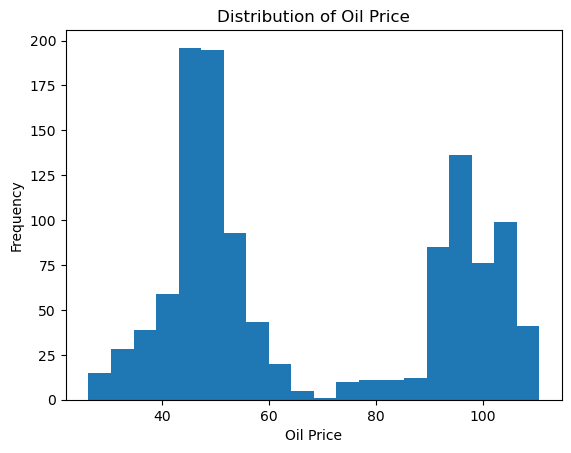

In [23]:
# Visualize the data
plt.hist(oil_df['dcoilwtico'].dropna(), bins=20)
plt.xlabel('Oil Price')
plt.ylabel('Frequency')
plt.title('Distribution of Oil Price')
plt.show()

The plot of the distribution of the oil price shows two successive bell-shaped curves suggesting the possibility of multiple subgroups or different underlying distributions within the data. Thus, the distribution of the data is not a normal distribution. A normal distribution would typically have a single bell-shaped curve centered around the mean.

Therefore, the measure of central tendency that should be used in handling the missing values is the median. The median is less sensitive to outliers and can provide a representative value for the central tendency in skewed distributions or distributions with multiple peaks.

#### Use the sklearn simple imputer to reolace the missing values with the median

In [24]:
# Create an instance of SimpleImputer with the chosen imputation strategy as median
imputer = SimpleImputer(strategy='median')

# Fit the imputer on the 'dcoilwtico' column
imputer.fit(oil_df[['dcoilwtico']])

# Impute missing values in the 'dcoilwtico' column
imputed_values = imputer.transform(oil_df[['dcoilwtico']])

# Replace the 'dcoilwtico' column with the imputed values
oil_df['dcoilwtico'] = imputed_values

In [25]:
# Check for missing values after handling
missing_values_after = oil_df['dcoilwtico'].isnull().sum()
missing_values_after

0

The missing values have been handled

### vi. Merging The Train Dataset with the Stores, Transactions, Holiday Events and Oil Datasets

In [27]:
# Merging the common columns ('store_nbr' and 'date') in the datasets using the merge() function
# Merge train_df with stores_df based on 'store_nbr' column
merged_df1 = train_df.merge(stores_df, on='store_nbr', how='left')

# Merge merged_df1 with transactions_df based on 'date' and 'store_nbr' columns
merged_df2 = merged_df1.merge(transactions_df, on=['date', 'store_nbr'], how='left')

# Merge merged_df2 with holidays_events_df based on 'date' column
merged_df3 = merged_df2.merge(holidays_events_df, on='date', how='left')

# Merge merged_df3 with oil_df based on 'date' column
merged_df = merged_df3.merge(oil_df, on='date', how='left')

# View the first five rows of the merged dataset
merged_df.head()

,id,date,store_nbr,family,sales,onpromotion,city,state,type_x,cluster,transactions,type_y,locale,locale_name,description,transferred,dcoilwtico
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,Quito,Pichincha,D,13,NaN,Holiday,National,Ecuador,Primer dia del ano,False,53.189999
1,1,2013-01-01,1,BABY CARE,0.0,0,Quito,Pichincha,D,13,NaN,Holiday,National,Ecuador,Primer dia del ano,False,53.189999
2,2,2013-01-01,1,BEAUTY,0.0,0,Quito,Pichincha,D,13,NaN,Holiday,National,Ecuador,Primer dia del ano,False,53.189999
3,3,2013-01-01,1,BEVERAGES,0.0,0,Quito,Pichincha,D,13,NaN,Holiday,National,Ecuador,Primer dia del ano,False,53.189999
4,4,2013-01-01,1,BOOKS,0.0,0,Quito,Pichincha,D,13,NaN,Holiday,National,Ecuador,Primer dia del ano,False,53.189999


In [28]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3054348 entries, 0 to 3054347
Data columns (total 17 columns):
 #   Column        Dtype         
---  ------        -----         
 0   id            int64         
 1   date          datetime64[ns]
 2   store_nbr     int64         
 3   family        object        
 4   sales         float64       
 5   onpromotion   int64         
 6   city          object        
 7   state         object        
 8   type_x        object        
 9   cluster       int64         
 10  transactions  float64       
 11  type_y        object        
 12  locale        object        
 13  locale_name   object        
 14  description   object        
 15  transferred   object        
 16  dcoilwtico    float64       
dtypes: datetime64[ns](1), float64(3), int64(4), object(9)
memory usage: 419.5+ MB


Two columns have been renamed as a result of the merging, type_x and type_y

In [29]:
# Check the unique values of the two unknown columns
print("Unique values of 'type_x':")
print(merged_df['type_x'].unique())
print()
print("Unique values of 'type_y':")
print(merged_df['type_y'].unique())

Unique values of 'type_x':
['D' 'C' 'B' 'E' 'A']

Unique values of 'type_y':
['Holiday' nan 'Work Day' 'Additional' 'Event' 'Transfer' 'Bridge']


- The type_x column represents the store type.
- The type_y column represents the holiday type.

In [30]:
# Renaming the columns with the approapriate names
merged_df = merged_df.rename(columns={"type_x": "store_type", "type_y": "holiday_type"})
merged_df.head()

,id,date,store_nbr,family,sales,onpromotion,city,state,store_type,cluster,transactions,holiday_type,locale,locale_name,description,transferred,dcoilwtico
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,Quito,Pichincha,D,13,NaN,Holiday,National,Ecuador,Primer dia del ano,False,53.189999
1,1,2013-01-01,1,BABY CARE,0.0,0,Quito,Pichincha,D,13,NaN,Holiday,National,Ecuador,Primer dia del ano,False,53.189999
2,2,2013-01-01,1,BEAUTY,0.0,0,Quito,Pichincha,D,13,NaN,Holiday,National,Ecuador,Primer dia del ano,False,53.189999
3,3,2013-01-01,1,BEVERAGES,0.0,0,Quito,Pichincha,D,13,NaN,Holiday,National,Ecuador,Primer dia del ano,False,53.189999
4,4,2013-01-01,1,BOOKS,0.0,0,Quito,Pichincha,D,13,NaN,Holiday,National,Ecuador,Primer dia del ano,False,53.189999


In [31]:
# Generate summary statistics and transpose the rows and columns of the resultant DataFrame.
# Transposing flips the DataFrame (the rows become columns and the columns become rows) for better readability
merged_df.describe().T

,count,mean,std,min,25%,50%,75%,max
id,3054348.0,1.504277e+06,866261.012008,0.000000,754676.750000,1.507572e+06,2.255120e+06,3.000887e+06
store_nbr,3054348.0,2.750000e+01,15.585787,1.000000,14.000000,2.750000e+01,4.100000e+01,5.400000e+01
sales,3054348.0,3.590209e+02,1107.285897,0.000000,0.000000,1.100000e+01,1.960110e+02,1.247170e+05
onpromotion,3054348.0,2.617480e+00,12.254939,0.000000,0.000000,0.000000e+00,0.000000e+00,7.410000e+02
cluster,3054348.0,8.481481e+00,4.649735,1.000000,4.000000,8.500000e+00,1.300000e+01,1.700000e+01
transactions,2805231.0,1.697071e+03,966.831652,5.000000,1046.000000,1.395000e+03,2.081000e+03,8.359000e+03
dcoilwtico,2175822.0,6.749375e+01,25.382446,26.190001,46.700001,5.319000e+01,9.549000e+01,1.106200e+02


In [32]:
# Checking for missing values in the merged dataset
# Check for missing values
missing_values = merged_df.isnull().sum()
missing_values

id                    0
date                  0
store_nbr             0
family                0
sales                 0
onpromotion           0
city                  0
state                 0
store_type            0
cluster               0
transactions     249117
holiday_type    2551824
locale          2551824
locale_name     2551824
description     2551824
transferred     2551824
dcoilwtico       878526
dtype: int64

In [33]:
# Calculate the percentage of missing values
percentage_missing = (merged_df.isnull().sum() / merged_df.shape[0]) * 100
percentage_missing.round(2).astype(str) + "%"

id                0.0%
date              0.0%
store_nbr         0.0%
family            0.0%
sales             0.0%
onpromotion       0.0%
city              0.0%
state             0.0%
store_type        0.0%
cluster           0.0%
transactions     8.16%
holiday_type    83.55%
locale          83.55%
locale_name     83.55%
description     83.55%
transferred     83.55%
dcoilwtico      28.76%
dtype: object

There are multiple columns with missing values:
- The 'transactions' column has a relatively low percentage of missing values, with 8.16% of the values missing.
- The 'holiday_type', 'locale', 'locale_name', 'description', and 'transferred' columns have a high percentage of missing values, with 83.55% of the values missing.
- The 'dcoilwtico' column has a moderate percentage of missing values, with 28.76% of the values missing.

To proceed with imputing the missing values, we can use the SimpleImputer class from scikit-learn, and select the appropriate imputation strategy for each column. For example, we can use the median strategy for imputing the missing values in the 'transactions' column, as the median is less sensitive to outliers and can provide a representative value for the central tendency in skewed distributions.